In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [6]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [7]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [47]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
returns = yen_futures.Settle.pct_change()*100
yen_futures['Returns'] = returns.copy()

# In this case, you may have to replace inf, -inf values with np.nan"s
yen_futures = yen_futures.dropna()
yen_futures

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,returns,Returns,Lagged_Return
Date,,,,,,,,,,,
2014-03-04,9859.0,9862.0,9776.0,9785.0,79.0,9780.0,137014.0,196097.0,-0.801298,-0.801298,0.346056
2014-03-06,9771.0,9773.0,9692.0,9705.0,69.0,9705.0,172188.0,199340.0,-0.766871,-0.766871,-0.801298
2014-03-07,9702.0,9724.0,9637.0,9681.0,24.0,9681.0,156252.0,201541.0,-0.247295,-0.247295,-0.766871
2014-03-10,9694.0,9714.0,9671.0,9691.0,10.0,9691.0,117210.0,195505.0,0.103295,0.103295,-0.247295
2014-03-11,9684.0,9724.0,9668.0,9718.0,27.0,9718.0,151075.0,181240.0,0.278609,0.278609,0.103295
...,...,...,...,...,...,...,...,...,...,...,...
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.564304,-0.369458


### Lagged Returns 

In [50]:
# Create a lagged return using the shift function
yen_futures['Lagged_Return'] = returns.shift()
yen_futures = yen_futures.dropna()
yen_futures

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,returns,Returns,Lagged_Return
Date,,,,,,,,,,,
2014-03-06,9771.0,9773.0,9692.0,9705.0,69.0,9705.0,172188.0,199340.0,-0.766871,-0.766871,-0.801298
2014-03-07,9702.0,9724.0,9637.0,9681.0,24.0,9681.0,156252.0,201541.0,-0.247295,-0.247295,-0.766871
2014-03-10,9694.0,9714.0,9671.0,9691.0,10.0,9691.0,117210.0,195505.0,0.103295,0.103295,-0.247295
2014-03-11,9684.0,9724.0,9668.0,9718.0,27.0,9718.0,151075.0,181240.0,0.278609,0.278609,0.103295
2014-03-12,9710.0,9752.0,9700.0,9739.0,21.0,9739.0,179062.0,163758.0,0.216094,0.216094,0.278609
...,...,...,...,...,...,...,...,...,...,...,...
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.564304,-0.369458


### Train Test Split

In [51]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]

In [53]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Returns"]
y_test = test["Returns"]

In [8]:
X_train

,Lagged_Return
Date,
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
2014-02-25,0.020502
...,...
2018-12-24,-0.187545
2018-12-26,0.834485
2018-12-27,-0.893346


# Linear Regression Model

In [54]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [55]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [56]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DD63BE5F28>,
      dtype=object)

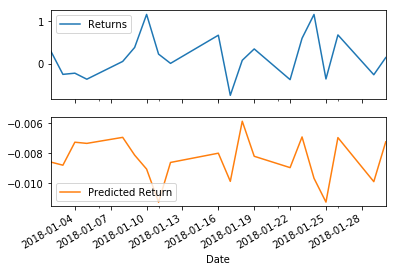

In [58]:
# Plot the first 20 predictions vs the true values
Results.head(20).plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [62]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Returns"],
    Results["Predicted Return"]
)


# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.41550594073209896


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [64]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Returns"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")



In-sample Root Mean Squared Error (RMSE): 0.5984051139468323


# Conclusions

YOUR CONCLUSIONS HERE!